# Loading Libraries

In [98]:
# Pandas & Numpy
import pandas as pd
import numpy as np 

# Visualization
import seaborn as sns 
from matplotlib import pyplot as plt 

# Tensorflow
import tensorflow as tf
from tensorflow import keras 

# Affinity Matrix 
from recommenders.datasets.sparse import AffinityMatrix

# Evaluation 
from recommenders.evaluation.python_evaluation import (
    precision_at_k,
    recall_at_k,
    ndcg_at_k,
    map_at_k
)
from sklearn.metrics import accuracy_score 

# Recomender Utilities
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.utils.python_utils import binarize
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.split_utils import min_rating_filter_pandas

# Multi VAE Model
from recommenders.models.vae.multinomial_vae import Mult_VAE

# System & OS
import sys
import os

# Turn of Warnings for Readability 
import warnings
warnings.filterwarnings("ignore")

# Import & Read Dataset

In [99]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/online_retail_ratings_train.csv", index_col=0)
test = pd.read_csv("../../00_Data/online_retail_ratings_test.csv", index_col=0)

In [100]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (357692, 3)
Shape of Test: 	 (89479, 3)


In [101]:
# Check Number of Unique Items and User in Train & Test 
print("Unique Users in Train:", train.CustomerID.nunique())
print("Unique Users in Test:", test.CustomerID.nunique())
print("Unique Items in Train:", train.StockCode.nunique())
print("Unique Items in Test:", test.StockCode.nunique())

Unique Users in Train: 3696
Unique Users in Test: 3696
Unique Items in Train: 2769
Unique Items in Test: 2769


In [102]:
# Concatenate both Dataset again for further Data Preparation
df = pd.concat([train, test], axis=0)

In [103]:
# Change name of columns 
df = df.rename(columns={'StockCode':'itemID', 'CustomerID':'userID', 'purchased':'rating'})
df.columns

Index(['itemID', 'userID', 'rating'], dtype='object')

# Data Filtering 

In [104]:
# Binarize the data (only keep ratings >= 0.5)
df_preferred = df[df['rating'] > 0]
print (df_preferred.shape)
df_low_rating = df[df['rating'] <= 0]


# Head of df_preferred
df_preferred.head(10)

(252517, 3)


,itemID,userID,rating
125778,1526,2425,1
7621,170,4134,1
10277,197,2711,1
134246,1592,1587,1
1846,43,3135,1
6252,166,1476,1
113247,1437,920,1
226836,2776,568,2
68565,999,3328,2
250848,3303,2967,1


In [105]:
# Head of df_low_rating
df_low_rating.head(10)

,itemID,userID,rating
370557,1551,223,-1
440452,2043,2392,-1
428223,1756,1936,-1
285547,2043,69,-1
302095,399,48,-1
317834,3249,1554,-1
257638,1931,1632,-2
339503,2079,431,-1
422694,1092,2473,-1
391314,1838,448,-1


In [106]:
# Keep users who clicked on at least 5 items
df = min_rating_filter_pandas(df_preferred, min_rating=5, filter_by="user")

# Keep movies that were clicked on by at least on 1 user
df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

In [107]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

# Compute sparsity after filtering
sparsity = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d interactions between %d users and %d items (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], sparsity * 100))

After filtering, there are 252513 interactions between 3686 users and 2769 items (sparsity: 2.474%)


# Split Data

In [108]:
unique_users = sorted(df.userID.unique())
np.random.seed(1)
unique_users = np.random.permutation(unique_users)

In [109]:
# Create train/validation/test users
n_users = len(unique_users)
print("Number of unique users:", n_users)

train_users = unique_users[:(n_users - 750 * 2)]
print("\nNumber of training users:", len(train_users))

val_users = unique_users[(n_users - 750 * 2) : (n_users - 750)]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[(n_users - 750):]
print("\nNumber of test users:", len(test_users))

Number of unique users: 3686

Number of training users: 2186

Number of validation users: 750

Number of test users: 750


In [110]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])


Number of training observations:  147724

Number of validation observations:  52353

Number of test observations:  52436


In [111]:
# Obtain list of unique items used in training set
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique items that consumed in training set", unique_train_items.size)

Number of unique items that consumed in training set 2769


In [112]:
# For validation set keep only items that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies items used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  52353

Number of test observations after filtering:  52436


In [148]:
test_set.shape[0] / (train_set.shape[0] + val_set.shape[0] + test_set.shape[0])

0.20765663549995445

# Click Matrix Generation

In [114]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [115]:
# Obtain the sparse matrix for train, validation and test sets
train_data, _, _ = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(2186, 2769)
(750, 2769)
(750, 2769)


In [116]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=1)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=1)

In [117]:
# Binarize train, validation and test data
train_data = binarize(a=train_data, threshold=0.5)
val_data = binarize(a=val_data, threshold=0.5)
test_data = binarize(a=test_data, threshold=0.5)

In [118]:
# Binarize validation data: training part  
val_data_tr = binarize(a=val_data_tr, threshold=0.5)

# Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize(a=val_data_te, threshold=0.5)

In [119]:
# Binarize test data: training part 
test_data_tr = binarize(a=test_data_tr, threshold=0.5)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=0.5)

 # Shapes and Dimensions after Data Preparation

In [145]:
# Interactions in Train & Test of Val & Test 
print("Interactions in Validation Training",val_data_tr.sum())
print("Interactions in Validation Test",val_data_te.sum())
print("Interactions in Test Training",test_data_tr.sum())
print("Interactions in Test Test",test_data_te.sum())

Interactions in Validation Training 39277.0
Interactions in Validation Test 13076.0
Interactions in Test Training 39323.0
Interactions in Test Test 13113.0


In [120]:
np.unique(test_data_tr)

array([0., 1.])

In [121]:
np.unique(train_data)

array([0., 1.])

In [122]:
np.unique(val_data)

array([0., 1.])

In [123]:
np.unique(val_data_tr)

array([0., 1.])

In [124]:
np.unique(test_data_te_ratings)

array([0, 1, 2])

In [125]:
np.unique(val_data_te_ratings)

array([0, 1, 2])

# Baseline Model Multi VAE

In [126]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [58]:
from tempfile import TemporaryDirectory

tmp_dir = TemporaryDirectory()
WEIGHTS_PATH = os.path.join(tmp_dir.name, "svae_weights.hdf5")

In [68]:
model_without_anneal = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                   original_dim=train_data.shape[1], # Number of unique items in the training set
                                   intermediate_dim=1000, 
                                   latent_dim=50, 
                                   n_epochs=50, 
                                   batch_size=50, 
                                   k=100,
                                   verbose=0,
                                   seed=1,
                                   drop_encoder=0.5,
                                   drop_decoder=0.5,
                                   annealing=False,
                                   beta=1.0,
                                   save_path=WEIGHTS_PATH
                                   )

In [69]:
with Timer() as t:
    model_without_anneal.fit(x_train=train_data, 
                        x_valid=val_data,
                        x_val_tr=val_data_tr, 
                        x_val_te=val_data_te_ratings, # with the original ratings 
                        mapper=am_val)
print("Took {} seconds for training.".format(t))

KeyboardInterrupt: 

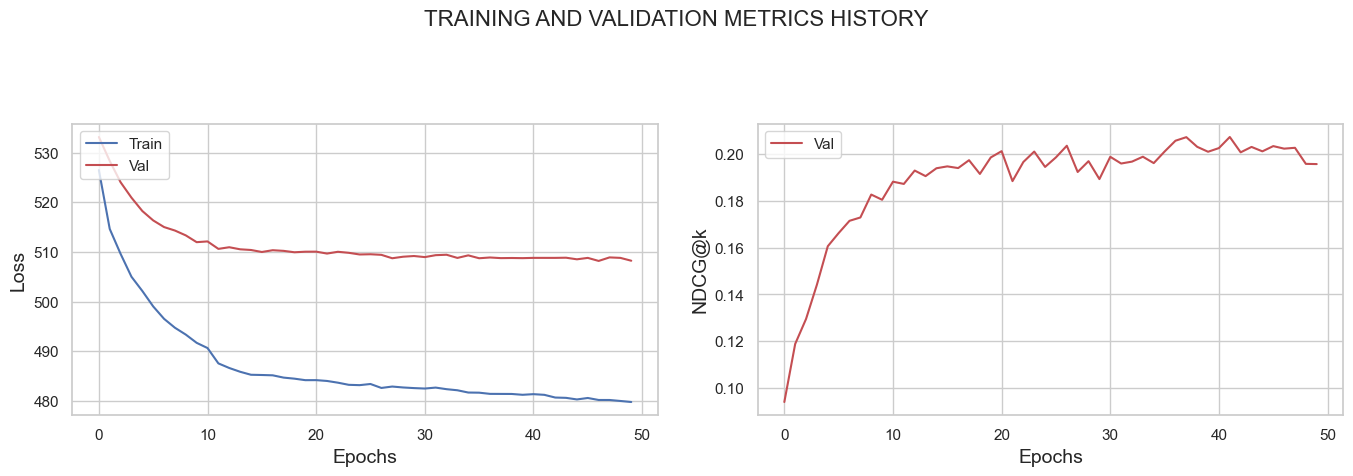

In [61]:
model_without_anneal.display_metrics() 

In [62]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True
                                                    )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_1 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_1 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_1 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_1 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_1,
      "NDCG@10:\t%f" % eval_ndcg_1,
      "Precision@10:\t%f" % eval_precision_1,
      "Recall@10: \t%f" % eval_recall_1, sep='\n')

Took 0.6928 seconds for prediction.
MAP@10:		0.035560
NDCG@10:	0.138120
Precision@10:	0.115067
Recall@10: 	0.081049


In [63]:
test_df.describe()

,userID,itemID,rating
count,13113.000000,13113.000000,13113.000000
mean,2192.521925,1550.841913,1.234424
std,1281.629891,811.215250,0.423654
min,17.000000,0.000000,1.000000
25%,1104.000000,936.000000,1.000000
50%,2091.000000,1520.000000,1.000000
75%,3348.000000,2089.000000,1.000000
max,4357.000000,3625.000000,2.000000


In [64]:
top_k_df.describe()

,userID,itemID,prediction
count,7500.000000,7500.000000,7500.000000
mean,2159.444000,1649.438267,2.832940
std,1282.586385,831.219480,0.442999
min,17.000000,7.000000,1.230721
25%,1037.000000,1039.000000,2.524217
50%,2074.500000,1570.000000,2.790007
75%,3305.000000,2133.000000,3.085558
max,4357.000000,3342.000000,5.235447


# Hyperparameter Tuning

In [127]:
# Set up Parameters
intermediate_dimension = [600, 800, 1000, 1200, 1400] 
latent_dimension = [50, 70, 90] 
batch_sizes = [50]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = Mult_VAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 

Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.10367496400846558
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.15838124390700198
Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.08146165927187403
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.12233585484246513
Recall@10 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.09898245987096055
Recall@20 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.1527668750636058
Recall@10 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.07654826057388896
Recall@20 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.12217314609305996
Recall@10 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.1012361156790337
Recall@20 for Int

In [128]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_initial = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_initial.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
18,1200,50,True,50,0.110716,0.164994,0.148933,0.115867
20,1200,70,True,50,0.109057,0.160783,0.144267,0.114133
24,1400,50,True,50,0.105908,0.159981,0.143600,0.112600
6,800,50,True,50,0.104613,0.156593,0.140667,0.110867
12,1000,50,True,50,0.103978,0.162538,0.141467,0.113667
22,1200,90,True,50,0.103873,0.155169,0.137333,0.109200
0,600,50,True,50,0.103675,0.158381,0.140667,0.111933
26,1400,70,True,50,0.101484,0.160843,0.142533,0.113467
4,600,90,True,50,0.101236,0.152780,0.137600,0.109333
28,1400,90,True,50,0.100680,0.154027,0.134133,0.107333


In [129]:
# Check Average Performance of Latent Dimensions
df_tuning_initial.groupby("latent_dimensions")['recall@10'].mean()

latent_dimensions
50    0.091553
70    0.088667
90    0.086091
Name: recall@10, dtype: float64

# Hyperparameter Tuning 2.0 

In [130]:
# Set up Parameters
intermediate_dimension = [1100, 1200, 1300, 1400, 1500] 
latent_dimension = [30, 40, 50, 60, 70] 
batch_sizes = [50]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = Mult_VAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 

Recall@10 for Intermediate Dim:  1100 Latent Dim:  30 Batch size:  50 Annealing:  True :	 0.10768801922004201
Recall@20 for Intermediate Dim:  1100 Latent Dim:  30 Batch size:  50 Annealing:  True :	 0.1580725763391716
Recall@10 for Intermediate Dim:  1100 Latent Dim:  30 Batch size:  50 Annealing:  False :	 0.07626144879865941
Recall@20 for Intermediate Dim:  1100 Latent Dim:  30 Batch size:  50 Annealing:  False :	 0.13373560621393274
Recall@10 for Intermediate Dim:  1100 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.10695524004393106
Recall@20 for Intermediate Dim:  1100 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.1618372233714736
Recall@10 for Intermediate Dim:  1100 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.07543295435004511
Recall@20 for Intermediate Dim:  1100 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.12222122058254509
Recall@10 for Intermediate Dim:  1100 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.10410519272766172
Recall@2

In [131]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_2 = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_2.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
10,1200,30,True,50,0.110749,0.166496,0.141067,0.113067
42,1500,40,True,50,0.110569,0.155665,0.146667,0.112667
32,1400,40,True,50,0.110487,0.166401,0.147600,0.115333
36,1400,60,True,50,0.109307,0.159159,0.141200,0.112333
40,1500,30,True,50,0.109221,0.165538,0.139733,0.113067
46,1500,60,True,50,0.108947,0.160513,0.144667,0.112133
34,1400,50,True,50,0.108298,0.157707,0.145467,0.113267
0,1100,30,True,50,0.107688,0.158073,0.144933,0.112800
48,1500,70,True,50,0.107435,0.163768,0.142533,0.114933
12,1200,40,True,50,0.107005,0.173137,0.141200,0.117533


In [142]:
# Average Performance based on Intermediate Dimension
df_tuning_2[df_tuning_2['annealing']==True].groupby("intermediate_dimensions")['recall@10'].mean().sort_values(ascending=False)

intermediate_dimensions
1500    0.107968
1400    0.106993
1200    0.105895
1100    0.105770
1300    0.105374
Name: recall@10, dtype: float64

In [143]:
# Average Performance based on Latent Dimension
df_tuning_2[df_tuning_2['annealing']==True].groupby("latent_dimensions")['recall@10'].mean().sort_values(ascending=False)

latent_dimensions
30    0.108224
40    0.107993
60    0.106692
50    0.104864
70    0.104227
Name: recall@10, dtype: float64

In [138]:
# Average Performance based on Annealing
df_tuning_2.groupby("annealing")['recall@10'].mean().sort_values(ascending=False)

annealing
True     0.106400
False    0.075892
Name: recall@10, dtype: float64

In [144]:
df_tuning_2[(df_tuning_2['intermediate_dimensions']==1200) & (df_tuning_2['annealing']==True) ].sort_values(by='recall@10',ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
10,1200,30,True,50,0.110749,0.166496,0.141067,0.113067
12,1200,40,True,50,0.107005,0.173137,0.141200,0.117533
16,1200,60,True,50,0.105086,0.163995,0.140800,0.114067
14,1200,50,True,50,0.103695,0.161472,0.141867,0.115600
18,1200,70,True,50,0.102942,0.154656,0.138267,0.108200


# Visualization of Hyperparameter Tuning

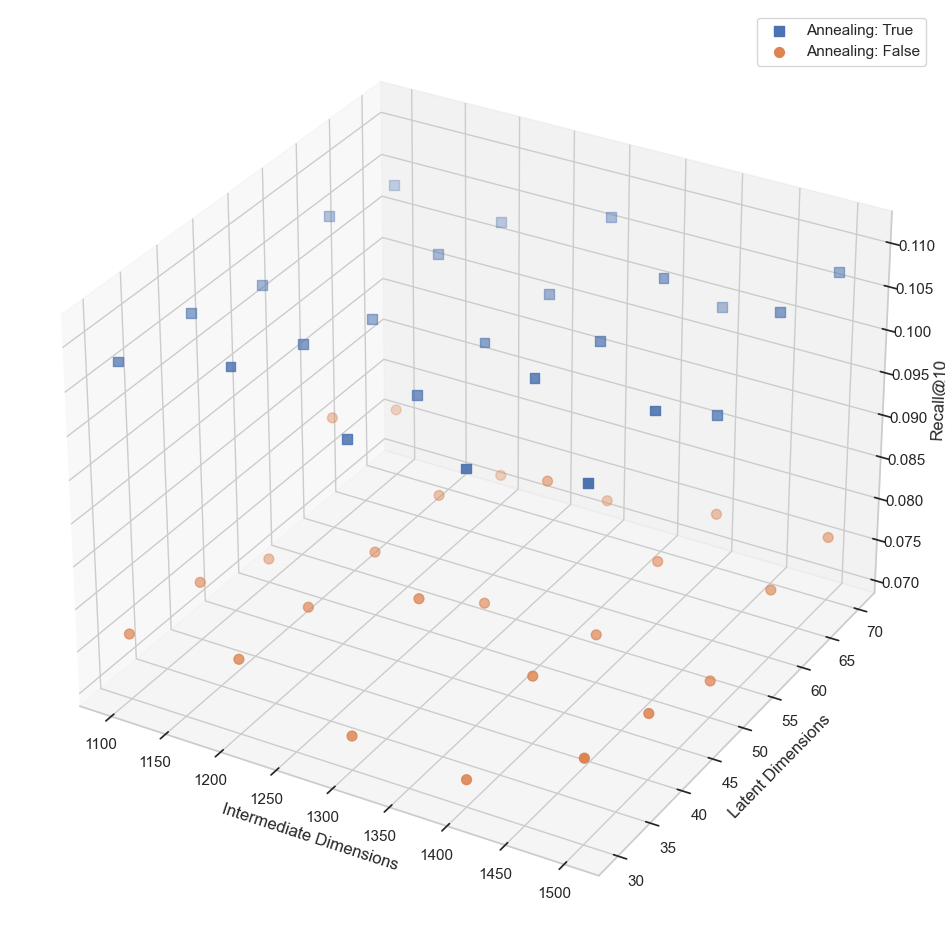

In [132]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 12))
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(projection='3d')

x = df_tuning_2.intermediate_dimensions
y = df_tuning_2['latent_dimensions']
z = df_tuning_2['recall@10']
annealing = df_tuning_2['annealing']

ax.set_xlabel('Intermediate Dimensions', fontname='Arial', fontsize=12)
ax.set_ylabel('Latent Dimensions', fontname='Arial', fontsize=12)
ax.set_zlabel('Recall@10', fontname='Arial', fontsize=12)

# Define different marker shapes based on the annealing values
marker_shapes = ['o', 's'] 

# Iterate over unique annealing values and plot each separately
for annealing_value in annealing.unique():
    indices = annealing == annealing_value
    ax.scatter(
        x[indices],
        y[indices],
        z[indices],
        marker=marker_shapes[annealing_value],
        s=50,
        label=f'Annealing: {annealing_value}'
    )

# Add a legend
ax.legend()

plt.show()
